# 確率的勾配降下法などを用いたNNの計算

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from google.colab import files
    print('Google Colab. 上での実行です')
    print('「ファイルを選択」から、notebook/commonフォルダの中身を全て選択し、アップロードしてください')
    print('===========')
    files.upload()
    !mkdir common
    !mv *.py ./common
except:
    print('ローカル環境での実行です')

from common.network import TwoLayerNet

ローカル環境での実行です


In [2]:
class SGD:
    def __init__(self, lr=0.01):
        """
        lr : 学習係数 learning rate
        """
        self.lr = lr
        
    def update(self, params, grads):
        """
        重みの更新
        """
        for key in params.keys():
            params[key] -= self.lr * grads[key]
            
class RMSProp:
    """
    RMSProp
    """
    def __init__(self, lr=0.01, rho=0.9):
        """
        lr : 学習係数 learning rate
        rho : 減衰率
        """
        self.lr = lr
        self.h = None
        self.rho = rho
        self.epsilon = 1e-6
        
    def update(self, params, grads):
        """
        重みの更新
        """
        if self.h is None:
            """
            初回のみ
            """
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] = self.rho * self.h[key] + (1 - self.rho) * grads[key] * grads[key]          
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + self.epsilon) ) # 原著論文に合わせてepsilonをルートの中に入れる            

In [7]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB ? eta 0:00:000:00:0101:10205.4 kB/s eta 0:00:01205.4 kB/s eta 0:00:01╸ 578.0/578.0 MB 205.4 kB/s eta 0:00:01205.4 kB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 134.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 185.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 197.1 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 341.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 314.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 264.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 242.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 251.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [6]:
# Load the MNIST dataset
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

train = X_train/255
test = X_test/255
train = train.reshape(-1, 28*28)
test = test.reshape(-1, 28*28)
train_labels = lb.fit_transform(y_train)
test_labels = lb.fit_transform(y_test)

x_train, t_train = train, train_labels
x_test, t_test = test, test_labels

ModuleNotFoundError: No module named 'tensorflow'

### [演習]
* 以下の処理を完成させましょう


In [4]:
x = train[:1000,:]
t = train_labels[:1000,:]

epochs = 50
batch_size = 25

def run(optimizer):
    # 繰り返し回数
    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)

    # 2層NNのオブジェクト生成
    tnet = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    
    np.random.seed(1234)
    seeds = np.random.randint(0, epochs-1, epochs)
#     print(seeds)
    
    for epoch in range(epochs):
#         print("epoch=%s"%epoch)

        # シャッフル
        idx = np.arange(xsize)
        np.random.seed(seeds[epoch])
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            x_train = x[mask]
            t_train = t[mask]

            # 勾配の計算 (誤差逆伝播法を用いる) 
            grads = tnet.gradient(x_train, t_train)

            # 更新
            optimizer.update(tnet.params, grads)

        ## 学習経過の記録

        # 訓練データにおけるloss
        train_loss.append(tnet.loss(x,  t))

        # テストデータにおけるloss
        test_loss.append(tnet.loss(test, test_labels))

        # 訓練データにて精度を確認
        train_accuracy.append(tnet.accuracy(x, t))

        # テストデータにて精度を算出
        test_accuracy.append(tnet.accuracy(test, test_labels))
        

    # lossのグラフ化
    df_log = pd.DataFrame({"train_loss":train_loss,
                 "test_loss":test_loss,
                 "train_accuracy":train_accuracy,
                 "test_accuracy":test_accuracy})
    df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
    plt.ylim([0,3])
    plt.ylabel("Accuracy or loss")
    plt.xlabel("epochs")
    plt.show()
#     print(df_log)
    
    return 

SGD, lr=0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


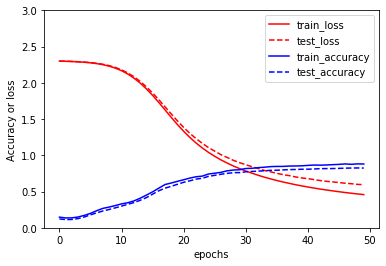

SGD, lr=0.1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


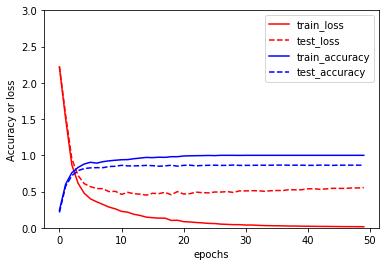

RMSProp, lr=0.01, rho=0.9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


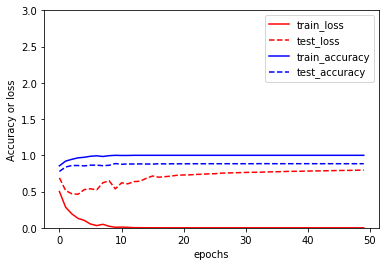

In [5]:
# 計算実行部分
# 完成したら最適化手法をいろいろ変えてみる

for  i in range(3):
    
    if i==0:
        print("SGD, lr=0.01")
        optimizer = SGD(lr=0.01)
        run(optimizer)
    elif i==1:
        print("SGD, lr=0.1")        
        optimizer = SGD(lr=0.1)
        run(optimizer)        
    elif i==2:
        print("RMSProp, lr=0.01, rho=0.9")        
        optimizer = RMSProp(lr=0.01, rho=0.9)
        run(optimizer)

### [演習]
* 最適化手法を変更し、結果がどのように変わるかを確認しましょう